Nishat Ahmed

Computer Vision Project 1

Following article was used for guidance: https://medium.com/@kirudang/deep-learning-computer-vision-using-transfer-learning-resnet-18-in-pytorch-skin-cancer-8d5b158893c5

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import random
import shutil
import sklearn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torch.optim as optim
import pickle
import torch.nn as nn
import seaborn as sn
import pandas as pd
from torchvision import *
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import time
import copy
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
from collections import Counter
import seaborn as sns

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data_dir = '/content/drive/MyDrive/Computer Vision/images'

# Custom transform to handle grayscale images
class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode == 'L':  # Check if image is grayscale
            img = img.convert('RGB')
        return img

# Define the transformations
transform = {
    'train': transforms.Compose([
        ConvertTo3Channels(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        ConvertTo3Channels(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        ConvertTo3Channels(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

class HandGestureDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
        self.label_map = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images, self.labels = self.load_data()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        label = self.label_map[label]
        return image, label

    def load_data(self):
        images = []
        labels = []
        for gesture in self.classes:
            folder_path = os.path.join(self.data_dir, gesture)
            print(f'Processing folder: {folder_path}')
            if not os.path.exists(folder_path):
                print(f"Folder does not exist: {folder_path}")
                continue
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if not os.path.isfile(file_path):
                    print(f"Not a file: {file_path}")
                    continue
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Verify the image to check for corruption
                        img = Image.open(file_path)  # Re-open the image after verification
                        images.append(img)
                        labels.append(gesture)
                        print(f"Loaded image: {file_path}")
                except Exception as e:
                    print(f"Failed to load image: {file_path} with error {e}")
                    continue
        print(f"Loaded {len(images)} images and {len(labels)} labels")
        return images, labels

# Create the dataset and check if images are loaded
dataset = HandGestureDataset(data_dir=data_dir)
print(f"Dataset contains {len(dataset)} samples")

# Split the dataset
if len(dataset) > 0:
    # Get the labels
    labels = [dataset.label_map[label] for label in dataset.labels]

    # Split dataset into train, validation, and test sets with stratification
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42, stratify=labels)
    train_indices, val_indices = train_test_split(train_indices, test_size=0.2, random_state=42, stratify=[labels[i] for i in train_indices])

    # Create subsets
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    # Apply appropriate transformations to each subset
    train_dataset.dataset.transform = transform['train']
    val_dataset.dataset.transform = transform['val']
    test_dataset.dataset.transform = transform['test']

    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    # Function to count the number of samples per class in a subset
    def count_samples_per_class(subset):
        label_counter = Counter()
        for _, label in subset:
            label_counter[label] += 1
        return label_counter

    # Count samples per class in each subset
    train_counter = count_samples_per_class(train_dataset)
    val_counter = count_samples_per_class(val_dataset)
    test_counter = count_samples_per_class(test_dataset)

    # Print the counts for each subset
    print("\nSamples per class in Train set:")
    for cls, count in train_counter.items():
        print(f"{dataset.classes[cls]}: {count}")

    print("\nSamples per class in Validation set:")
    for cls, count in val_counter.items():
        print(f"{dataset.classes[cls]}: {count}")

    print("\nSamples per class in Test set:")
    for cls, count in test_counter.items():
        print(f"{dataset.classes[cls]}: {count}")

else:
    print("No images loaded, please check the dataset directory and files.")

Streaming output truncated to the last 5000 lines.
Loaded image: /content/drive/MyDrive/Computer Vision/images/call_me/4385.jpg
Loaded image: /content/drive/MyDrive/Computer Vision/images/call_me/4682.jpg
Loaded image: /content/drive/MyDrive/Computer Vision/images/call_me/5199.jpg
Loaded image: /content/drive/MyDrive/Computer Vision/images/call_me/4465.jpg
Loaded image: /content/drive/MyDrive/Computer Vision/images/call_me/4941.jpg
Loaded image: /content/drive/MyDrive/Computer Vision/images/call_me/3527.jpg
Loaded image: /content/drive/MyDrive/Computer Vision/images/call_me/5006.jpg
Loaded image: /content/drive/MyDrive/Computer Vision/images/call_me/4546.jpg
Loaded image: /content/drive/MyDrive/Computer Vision/images/call_me/3944.jpg
Loaded image: /content/drive/MyDrive/Computer Vision/images/call_me/4355.jpg
Loaded image: /content/drive/MyDrive/Computer Vision/images/call_me/3713.jpg
Loaded image: /content/drive/MyDrive/Computer Vision/images/call_me/3952.jpg
Loaded image: /content/dr

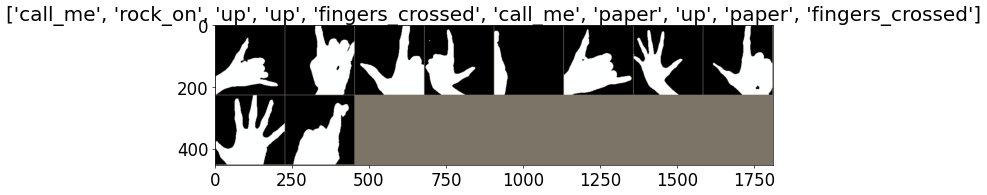

In [18]:
class_names = sorted([d for d in os.listdir('/content/drive/MyDrive/Computer Vision/images') if os.path.isdir(os.path.join('/content/drive/MyDrive/Computer Vision/images', d))])

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(val_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:10])
imshow(out, title=[class_names[x] for x in classes[:10]])

In [10]:
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_features = model.fc.in_features
print('Number of features from pre-trained model', num_features)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


Number of features from pre-trained model 2048


In [11]:
model.fc = nn.Linear(num_features, 10)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [19]:
#Training
train_loss = []
train_acc = []
val_loss = []
val_acc = []

num_epochs = 20
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples * 100.0

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    print(f"[Train] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}%")

    # Validation phase
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples * 100.0

        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc)

        print(f"[Val] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}%")

print(f"Training complete in {(time.time() - start_time) / 60:.2f} minutes")

Epoch 1/20
[Train] Loss: 0.8882 Acc: 91.3264%
[Val] Loss: 0.8973 Acc: 90.8224%
Epoch 2/20
[Train] Loss: 0.7200 Acc: 93.4426%
[Val] Loss: 0.7544 Acc: 92.3719%
Epoch 3/20
[Train] Loss: 0.5750 Acc: 95.2608%
[Val] Loss: 0.6051 Acc: 92.6103%
Epoch 4/20
[Train] Loss: 0.4615 Acc: 96.2146%
[Val] Loss: 0.4947 Acc: 94.8749%
Epoch 5/20
[Train] Loss: 0.3769 Acc: 96.6915%
[Val] Loss: 0.3879 Acc: 95.8284%
Epoch 6/20
[Train] Loss: 0.3113 Acc: 97.6751%
[Val] Loss: 0.4655 Acc: 94.6365%
Epoch 7/20
[Train] Loss: 0.2614 Acc: 97.6751%
[Val] Loss: 0.3001 Acc: 96.1859%
Epoch 8/20
[Train] Loss: 0.2195 Acc: 98.2712%
[Val] Loss: 0.3261 Acc: 95.5900%
Epoch 9/20
[Train] Loss: 0.1969 Acc: 98.1818%
[Val] Loss: 0.3104 Acc: 96.4243%
Epoch 10/20
[Train] Loss: 0.1615 Acc: 98.7481%
[Val] Loss: 0.2181 Acc: 96.6627%
Epoch 11/20
[Train] Loss: 0.1406 Acc: 98.9568%
[Val] Loss: 0.1951 Acc: 97.4970%
Epoch 12/20
[Train] Loss: 0.1314 Acc: 98.9270%
[Val] Loss: 0.1590 Acc: 97.6162%
Epoch 13/20
[Train] Loss: 0.1162 Acc: 98.9270%
[V

In [35]:
save_dir = '/content/drive/MyDrive/CV_Models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'handgesture_resnet_50_500.pth')
torch.save(model.state_dict(), save_path)

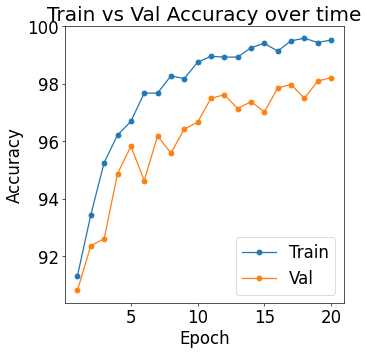

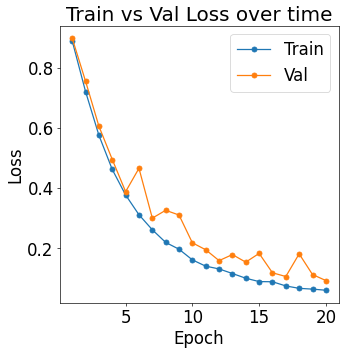

In [20]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_acc,'-o')
plt.plot(np.arange(1,num_epochs+1), val_acc,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])
plt.title('Train vs Val Accuracy over time')
plt.show()
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_loss,'-o')
plt.plot(np.arange(1,num_epochs+1), val_loss,'-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])
plt.title('Train vs Val Loss over time')
plt.show()

In [21]:
total = 0
correct = 0

model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs) # Feed Network
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 98.38%


Predictions, Ground Truth, and Images for a Random Subset:
Sample 1
Prediction: rock_on, Ground Truth: rock_on


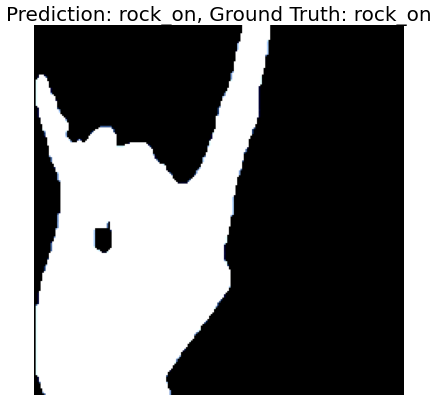

Sample 2
Prediction: rock_on, Ground Truth: rock_on


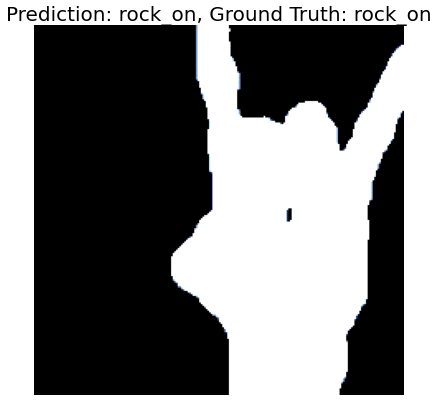

Sample 3
Prediction: thumbs, Ground Truth: thumbs


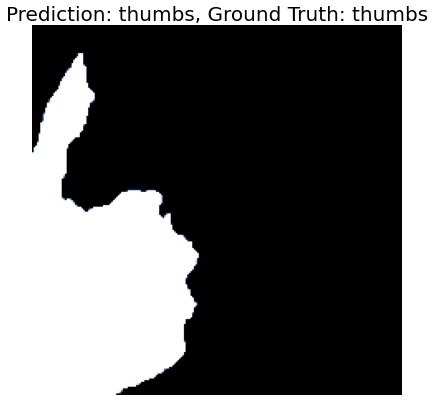

Sample 4
Prediction: rock, Ground Truth: rock


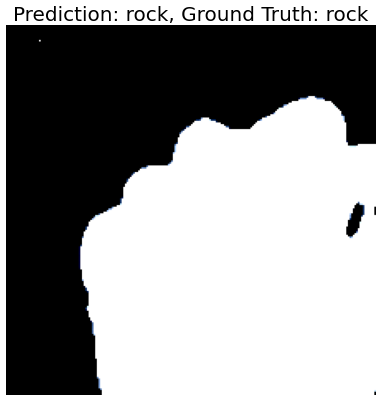

Sample 5
Prediction: scissor, Ground Truth: scissor


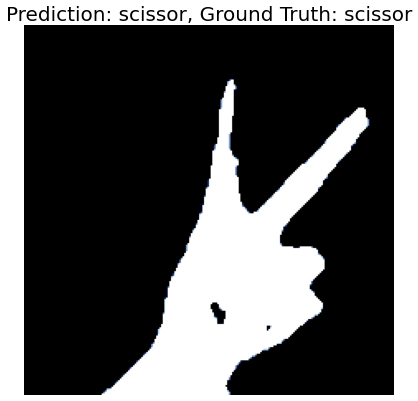

Sample 6
Prediction: rock_on, Ground Truth: rock_on


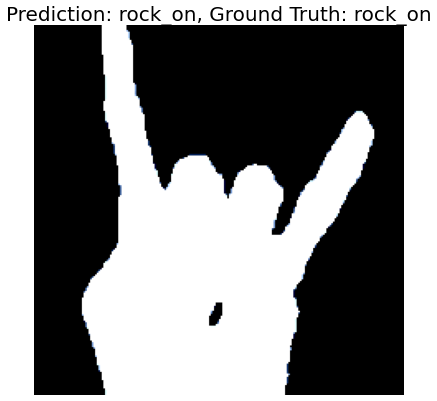

Sample 7
Prediction: rock_on, Ground Truth: rock_on


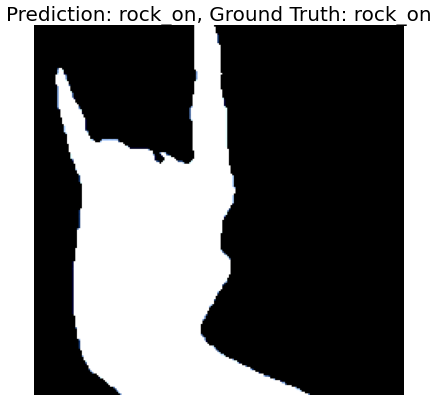

Sample 8
Prediction: peace, Ground Truth: peace


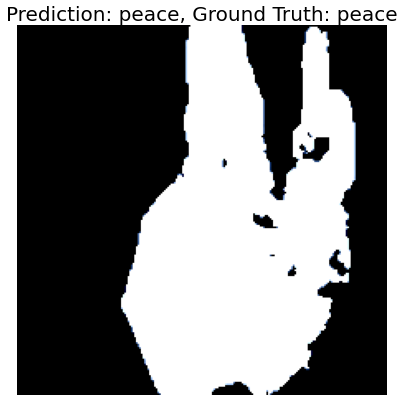

Sample 9
Prediction: call_me, Ground Truth: call_me


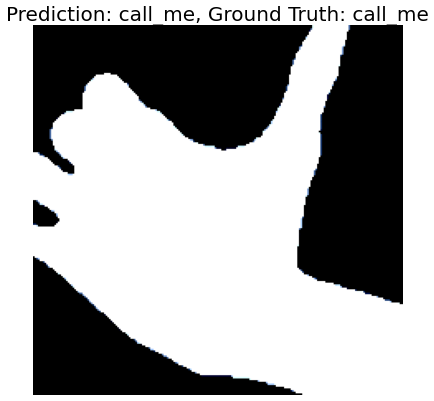

Sample 10
Prediction: scissor, Ground Truth: scissor


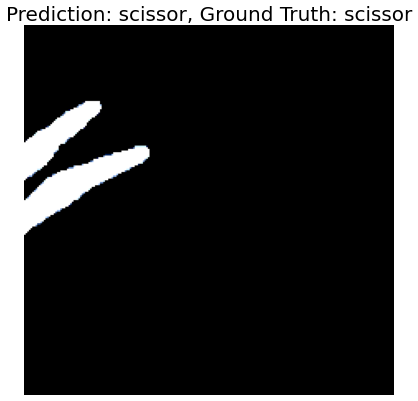

Accuracy: 0.9838
Classification Report:
                 precision    recall  f1-score   support

        call_me       1.00      0.99      1.00       105
fingers_crossed       0.97      0.96      0.97       101
           okay       0.99      1.00      1.00       108
          paper       1.00      0.98      0.99       108
          peace       0.98      0.98      0.98       105
           rock       1.00      0.99      1.00       102
        rock_on       0.98      0.98      0.98       106
        scissor       0.99      0.96      0.98       105
         thumbs       0.96      1.00      0.98       108
             up       0.96      0.99      0.98       101

       accuracy                           0.98      1049
      macro avg       0.98      0.98      0.98      1049
   weighted avg       0.98      0.98      0.98      1049



In [41]:
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

model.eval()

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    for data, labels in test_dataloader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(data.cpu().numpy())

# Select a random subset of the data
subset_indices = random.sample(range(len(all_preds)), 10)  # Adjust the number of samples as needed
subset_preds = [all_preds[i] for i in subset_indices]
subset_labels = [all_labels[i] for i in subset_indices]
subset_images = [all_images[i] for i in subset_indices]

# Print Predictions, Labels, and Images for the Random Subset
print("Predictions, Ground Truth, and Images for a Random Subset:")
for i, (pred, label, image) in enumerate(zip(subset_preds, subset_labels, subset_images)):
    try:
        pred_class = class_names[pred]
        label_class = class_names[label]
    except IndexError:
        print(f"IndexError: Prediction index {pred} or label index {label} is out of range.")
        continue

    print(f"Sample {i+1}")
    print(f"Prediction: {pred_class}, Ground Truth: {label_class}")
    plt.imshow(np.transpose(image, (1, 2, 0)))  # Assuming image format is (C, H, W)
    plt.title(f"Prediction: {pred_class}, Ground Truth: {label_class}")
    plt.axis('off')
    plt.show()

# Evaluate performance
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=class_names)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)


Predictions, Ground Truth, and Images for a Random Subset:
Sample 1
Prediction: fingers_crossed, Ground Truth: fingers_crossed


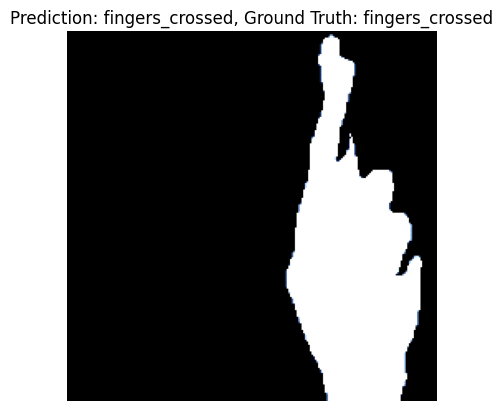

Sample 2
Prediction: rock_on, Ground Truth: rock_on


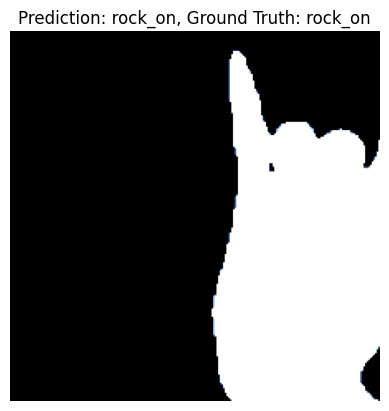

Sample 3
Prediction: paper, Ground Truth: paper


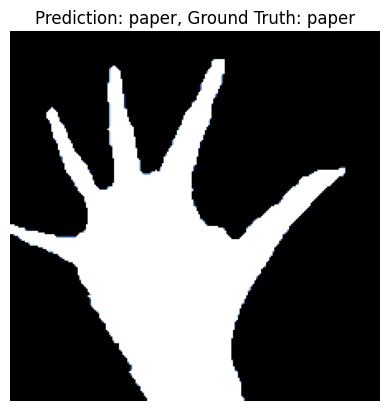

Sample 4
Prediction: thumbs, Ground Truth: thumbs


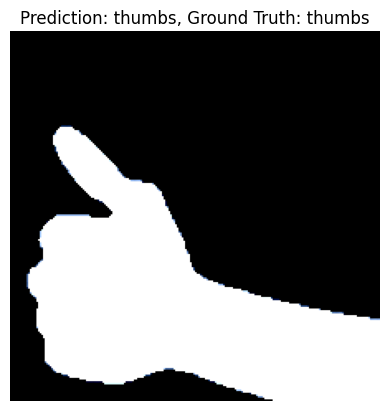

Sample 5
Prediction: rock_on, Ground Truth: rock_on


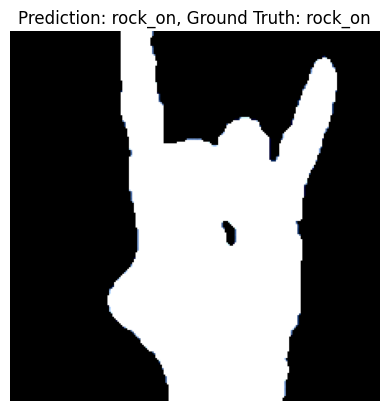

Sample 6
Prediction: rock_on, Ground Truth: rock_on


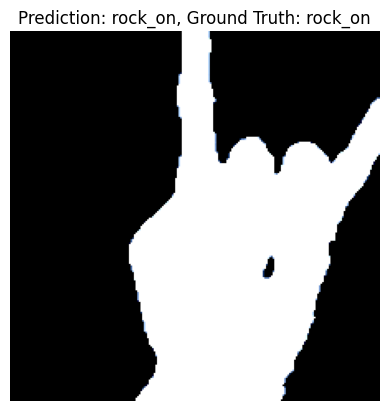

Sample 7
Prediction: up, Ground Truth: fingers_crossed


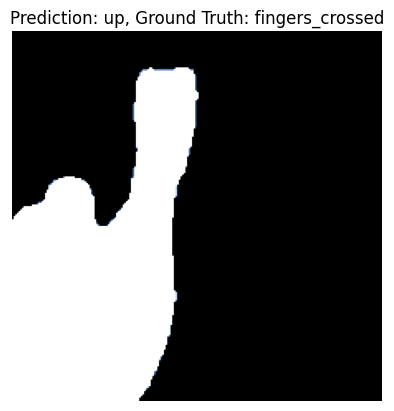

Sample 8
Prediction: rock, Ground Truth: rock


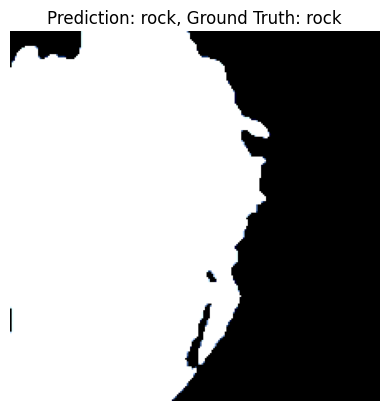

Sample 9
Prediction: call_me, Ground Truth: call_me


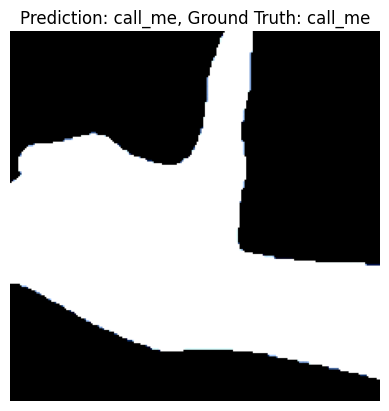

Sample 10
Prediction: up, Ground Truth: up


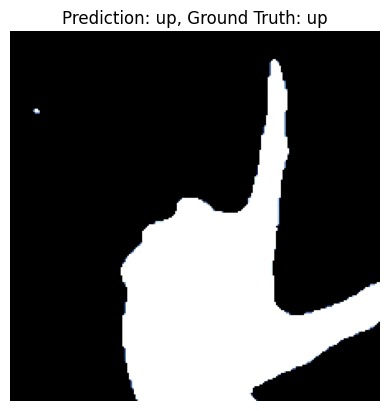

Accuracy: 0.9800


In [8]:
data_dir = '/content/drive/MyDrive/Computer Vision/images'
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

model_path = '/content/drive/MyDrive/CV_Models/handgesture_resnet_50_500.pth'

# Check if the model file exists
if not os.path.exists(model_path):
    print(f"Model file not found at {model_path}")
else:
    try:
        # Load your trained model
        model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 10)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = model.to(device)

        model.load_state_dict(torch.load(model_path))
        model.eval()

        all_preds = []
        all_labels = []
        all_images = []

        with torch.no_grad():
            for data, labels in test_dataloader:
                data = data.to(device)
                labels = labels.to(device)
                outputs = model(data)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_images.extend(data.cpu().numpy())

        # Select a random subset of the data
        subset_indices = random.sample(range(len(all_preds)), 10)  # Adjust the number of samples as needed
        subset_preds = [all_preds[i] for i in subset_indices]
        subset_labels = [all_labels[i] for i in subset_indices]
        subset_images = [all_images[i] for i in subset_indices]

        # Print Predictions, Labels, and Images for the Random Subset
        print("Predictions, Ground Truth, and Images for a Random Subset:")
        for i, (pred, label, image) in enumerate(zip(subset_preds, subset_labels, subset_images)):
            try:
                pred_class = class_names[pred]
                label_class = class_names[label]
            except IndexError:
                print(f"IndexError: Prediction index {pred} or label index {label} is out of range.")
                continue

            print(f"Sample {i+1}")
            print(f"Prediction: {pred_class}, Ground Truth: {label_class}")
            plt.imshow(np.transpose(image, (1, 2, 0)))  # Assuming image format is (C, H, W)
            plt.title(f"Prediction: {pred_class}, Ground Truth: {label_class}")
            plt.axis('off')
            plt.show()

        # Evaluate performance
        accuracy = accuracy_score(all_labels, all_preds)

        print(f'Accuracy: {accuracy:.4f}')

    except EOFError:
        print(f"EOFError: The file at {model_path} might be corrupted or incomplete.")
    except Exception as e:
        print(f"An error occurred: {e}")
